# <center> Raport lokalnego przewoźnika Wesoły Autobus S.A.
## <center> Analiza płynności firmy w zależności od ceny biletów i liczby zakupionych autobusów

<br>Zaawansowane Modelowanie Symulacyjne
<br>234060-0723

**Autorzy**
<br>Filip Mordarski, 76671 
<br>Damian Głowacki, 72384 
<br>Mateusz Dalba, 68734
<br>Dorota Szczęsna, 72569

In [1]:
import numpy as np
import numpy.random as random
import random as r
from collections import Counter
from collections import OrderedDict
import pandas as pd
import warnings
from statistics import mean 
import matplotlib.cm as cm
from mpl_toolkits import mplot3d
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn.model_selection import train_test_split
warnings.filterwarnings('ignore')

In [2]:
stops = ["Małe Bobry", "Potok Górny", "Potok Dolny", "Dworzec", "Fabryka", 
           "Dworzec_2", "Potok Dolny_2", "Potok Górny_2", "Małe Bobry_2"]

In [3]:
sns.set_style('whitegrid')

In [4]:
# Nowa funkcja ceny - wybieramy tą
def f(cena=0):
    if cena <= 6:
        wspolczynnik = round(4/(1/2*cena+1)-1,3)
    else: 
        wspolczynnik = 0
    return wspolczynnik

In [5]:
def simulate_passengers(cena):
    passengers = {}
    for hour in range(24):
        passengers[hour] = {}
    for stop in stops:
        if stop != "Małe Bobry_2":
            wsp_ceny=f(cena)
            if stop == "Dworzec":
                number_passengers_in = random.gamma(6, 2, size=int(1200*wsp_ceny)).round(0)
                number_passengers_in = number_passengers_in[(number_passengers_in >=0) & \
                                                            (number_passengers_in <=23)]
                number_passengers_out = random.gamma(6, 2, size=int(1200*wsp_ceny)).round(0)
                number_passengers_out = number_passengers_out[(number_passengers_out >=0) & \
                                                              (number_passengers_out <=23)]
            elif '2' in stop:
                number_passengers_in = random.gamma(9, 1, size=int(400*wsp_ceny)).round(0).clip(0, 23)
                number_passengers_in = np.array([24-value for value in number_passengers_in])
                number_passengers_out = random.gamma(9, 1, size=int(800*wsp_ceny)).round(0).clip(0, 23)
                number_passengers_out = np.array([24-value for value in number_passengers_out])
            elif stop == "Fabryka": 
                number_passengers_in = random.gamma(8, 1, size=int(1200*wsp_ceny)).round(0).clip(0, 23)
                number_passengers_in = np.array([24-value for value in number_passengers_in])
            else: 
                number_passengers_in = random.gamma(9, 1, size=int(800*wsp_ceny)).round(0).clip(0, 23)
                number_passengers_out = random.gamma(9, 1, size=int(400*wsp_ceny)).round(0).clip(0, 23)
            for hour in range(24):
                passengers[hour][stop] = {}
                passengers[hour][stop]["in"] = len(number_passengers_in[number_passengers_in == hour])
                if stop not in ["Małe Bobry", "Małe Bobry_2", "Fabryka"]:
                    passengers[hour][stop]["out"] = len(number_passengers_out\
                                                              [number_passengers_out == hour])
    return passengers

## 1. Executive summary

## 2. Opis organizacji

<br> Symulacja jest przeprowadzana dla lokalnego przewoźnika Wesoły Autobus S.A. 

## 3. Opis problemu
<br>W związku ze wzrostem zatrudnienia w lokalnej fabryce firma planuje zoptymalizować istniejącą linię łączącą lokalne miejscowości z fabryką, głównym miejscem pracy większości mieszkańców. Obecnie istniejące połączenie jest nieefektywne, kursuje za mało autobusów i nie wszyscy pasażerowie są w stanie pojechać autobusem o zaplanowanej godzinie. Dodatkowo zyski firmy są na zbyt niskim poziomie, aby firma mogła dobrze prosperować i inwestować w dalszy rozwój.

Prezes firmy Wesoły Autobus S.A. zwrócił się do nas z prośbą o przygotowanie raportu z rekomendacjami na usprawnienie linii łączącej Małe Bobry z fabryką. Autobus dojeżdzając do przystanku "Fabryka" robi pętlę, to znaczy wraca tą samą trasą, odwiedzając te same przystanki. W zależności od pory dnia oraz przystanka liczba pasażerów jest inna. Prezes firmy przekazał nam informacje, jak wygląda średnia liczba pasażerów wsiadających oraz wysiadających na danym przystanku z uwzględnieniem godziny kursu. Według naszej analizy liczba pasażerów na przystankach przyjmuje rozkład gamma. Gdzie wartości wylosowane z tego rozkładu (zaokrąglone do zerowego miejsca po przecinku) są godzinami odjazdu bądź przyjazdu pasażerów. Zgodnie z wynikami naszych analiz liczby pasażerów na danych przystankach przyjęliśmy następujące rozkłady gamma:


#### Godziny **wsiadania** pasażerów na przystanku
- **Małe Bobry** przyjmują rozkład gamma z parametrem kształtu równym **9** oraz parametrem skali równym **1**
  <br>Sumaryczna liczba pasażerów wsiadających na tym przystanku w ciągu dnia wynosi **800**
- **Potok** Górny przyjmują rozkład gamma z parametrem kształtu równym **9** oraz parametrem skali równym **1**
  <br>Sumaryczna liczba pasażerów wsiadających na tym przystanku w ciągu dnia wynosi **800**
- **Potok Dolny** przyjmują rozkład gamma z parametrem kształtu równym **9** oraz parametrem skali równym **1**
  <br>Sumaryczna liczba pasażerów wsiadających na tym przystanku w ciągu dnia wynosi **800**
- **Dworzec** przyjmują rozkład gamma z parametrem kształtu równym **6** oraz parametrem skali równym **2**
  <br>Sumaryczna liczba pasażerów wsiadających na tym przystanku w ciągu dnia wynosi **1200**
- **Fabryka** przyjmują rozkład gamma z parametrem kształtu równym **8** oraz parametrem skali równym **1**
  <br>Sumaryczna liczba pasażerów wsiadających na tym przystanku w ciągu dnia wynosi **1200**
- **Dworzec_2** przyjmują rozkład gamma z parametrem kształtu równym **9** oraz parametrem skali równym **1**
   <br>Sumaryczna liczba pasażerów wsiadających na tym przystanku w ciągu dnia wynosi **400**
- **Potok Dolny_2** przyjmują rozkład gamma z parametrem kształtu równym **9** oraz parametrem skali równym **1**
    <br>Sumaryczna liczba pasażerów wsiadających na tym przystanku w ciągu dnia wynosi **400**
- **Potok Górny_2** przyjmują rozkład gamma z parametrem kształtu równym **9** oraz parametrem skali równym **1**
    <br>Sumaryczna liczba pasażerów wsiadających na tym przystanku w ciągu dnia wynosi **400**

**Uwaga**: przystanki z dopiskiem "2" oznaczają przystanki, które napotyka bus jadąc z powrotem z Fabryki do przystanku Małe Bobry. Dla tych przystanków od wylosowanych wartości została odjęta liczba 24, aby zwiększyć liczbę pasażerów wracających w godzinach popołudniowych z pracy do domu.

#### Godziny **wysiadania** pasażerów na przystankach 
Parametry rozkładów gamma dla pasażerów wysiadających na poszczególnych przystankach jest taka sama jak dla pasażerów wsiadających. Różnica jest natomiast w sumarycznej liczbie pasażerów, którą przedstawiono poniżej dla każdego przystanku.

- **Małe Bobry** Sumaryczna liczba pasażerów wysiadających na tym przystanku w ciągu dnia wynosi **400**
- **Potok** Sumaryczna liczba pasażerów wysiadających na tym przystanku w ciągu dnia wynosi **400**
- **Potok Dolny** Sumaryczna liczba pasażerów wysiadających na tym przystanku w ciągu dnia wynosi **400**
- **Dworzec** Sumaryczna liczba pasażerów wysiadających na tym przystanku w ciągu dnia wynosi **1200**
- **Dworzec_2** Sumaryczna liczba pasażerów wysiadających na tym przystanku w ciągu dnia wynosi **800**
- **Potok Dolny_2** Sumaryczna liczba pasażerów wysiadających na tym przystanku w ciągu dnia wynosi **800**
- **Potok Górny_2** Sumaryczna liczba pasażerów wysiadających na tym przystanku w ciągu dnia wynosi **800**

**Uwaga**: Dla przystanku "Fabryka" nie były losowane godziny wysiadania pasażerów, ponieważ zakładamy, że wysiadają tam wszyscy jadący danym busem pasażerowie.

Poniżej przedstawiono na dwóch wykresach liczbę pasażerów wsiadających oraz wysiadających na konkretnym przystanku o danej godzinie.

Klienci także są wrażliwi na wartość ceny biletu, jeżeli cena będzie za wysoka to pojadą do pracy samochodami, pociągiem lub taksówkami. Z tego względu liczba pasażerów w ciągu dnia na danym przystanku jest uzależniona od ceny biletu. Powyższe wartości liczby pasażerów na danych przystankach odzwierciedlają sytuację gdy cena biletu wynosi 2 zł. Wraz ze zmianą ceny, zmienia się współczynnik, który wpływa na liczbę pasażerów na danym przystanku w ciągu dnia. Współczynnik jest obliczany za pomocą następującej funkcji jeśli cena jest mniejsza bądź równa 6: $f(x) = \frac{4}{0,5x+1}-1$, gdzie x to cena biletu. Jeśli cena jest większa od 6, współczynnik jest równy 0, co oznacza, że nie ma popytu na usługi transportowe naszej firmy. Poniższy wykres przedstawia przebieg funkcji, odpowiedzialnej za obliczenie współczynnika.

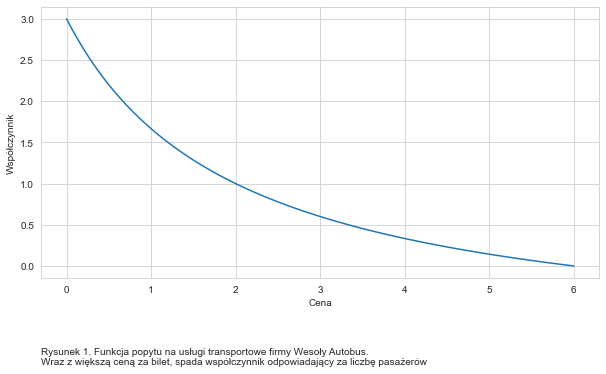

In [6]:
x = np.linspace(0,6,10000)
y = [f(value) for value in x]
fig, ax = plt.subplots(figsize=(10,5)) 
plt.plot(x, y)
plt.xlabel('Cena')
plt.ylabel('Współczynnik')
plt.text(-0.3, -1.2, "Rysunek 1. Funkcja popytu na usługi transportowe firmy Wesoły Autobus.\n"
                     "Wraz z większą ceną za bilet, spada współczynnik odpowiadający za liczbę pasażerów", ha='left');

Na poniższym wykresie możemy zaobserwować jak zmienia się liczba pasażerów wsiadających na wszystkich przystankach w zależności od godziny kursu.

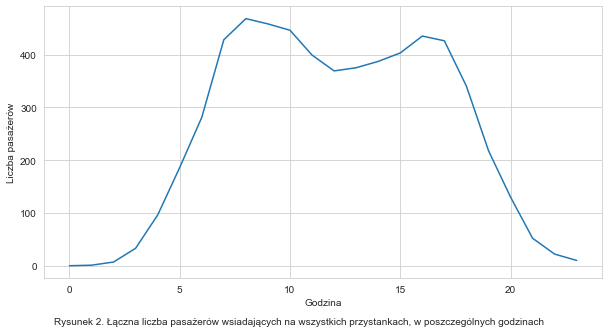

In [7]:
# Łaczna liczba pasażerów wsiadających

cena_biletu=2
passengers = simulate_passengers(cena_biletu)

lista_h = list(range(0,24))
lista_pass = []
pass_l = 0
for key,value in passengers.items():
    pass_l = 0
    for k, v in value.items():
        pass_l += (v['in'])
    lista_pass.append(pass_l)
df = pd.DataFrame({'Godzina': lista_h, 'Liczba': lista_pass} )
fig, ax = plt.subplots(figsize=(10,5)) 
plt.plot(lista_h, lista_pass)
plt.xlabel('Godzina')
plt.ylabel('Liczba pasażerów')
plt.text(-.7, -110,'Rysunek 2. Łączna liczba pasażerów wsiadających na wszystkich przystankach, w poszczególnych godzinach');

Na poniższym wykresie możemy zaobserwować jak zmienia się liczba pasażerów wysiadających na wszystkich przystankach w zależności od godziny kursu.

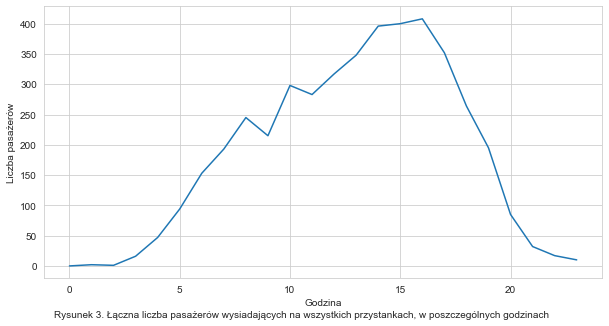

In [8]:
# Łaczna liczba pasażerów wysiadających

lista_h = list(range(0,24))
lista_pass_out = []
pass_l = 0
for key2,value2 in passengers.items():
    pass_l = 0
    for k2, v2 in value2.items():
        if 'out' not in v2:
            pass_l += 0
        else:
            pass_l += v2['out']
    lista_pass_out.append(pass_l)
df = pd.DataFrame({'Godzina': lista_h, 'Liczba': lista_pass_out} )
fig, ax = plt.subplots(figsize=(10,5)) 
plt.plot(lista_h, lista_pass_out)
plt.xlabel('Godzina')
plt.ylabel('Liczba pasażerów')
plt.text(-.7, -84, 'Rysunek 3. Łączna liczba pasażerów wysiadających na wszystkich przystankach, w poszczególnych godzinach');

Poniższy wykres przedstawia zależność liczby wsiadających pasażerów a godziną kursu w podziale na przystanki.

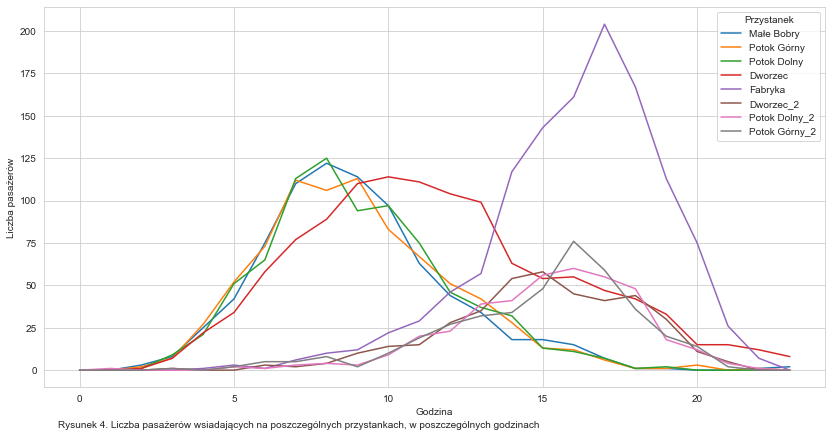

In [10]:
lista_h = []
for h in range(0,24):
    lista = [h]*8
    lista_h += lista
stops = []

for i in range(0,24):
    s = ["Małe Bobry", "Potok Górny", "Potok Dolny", "Dworzec", "Fabryka", 
           "Dworzec_2", "Potok Dolny_2", "Potok Górny_2"]
    stops += s
    
lista_pass = []
for key,value in passengers.items():
    for k, v in value.items():
        lista_pass.append(v['in'])
df = pd.DataFrame({'Godzina': lista_h, 'Przystanek': stops, 'Liczba pasażerów': lista_pass} )
fig, ax = plt.subplots(figsize=(14,7)) 
sns.lineplot(data=df,x='Godzina',y='Liczba pasażerów',hue='Przystanek')
plt.text(-.7, -34, 'Rysunek 4. Liczba pasażerów wsiadających na poszczególnych przystankach, w poszczególnych godzinach');

Poniższy wykres przedstawia zależność liczby wysiadających pasażerów a godziną kursu w podziale na przystanki.

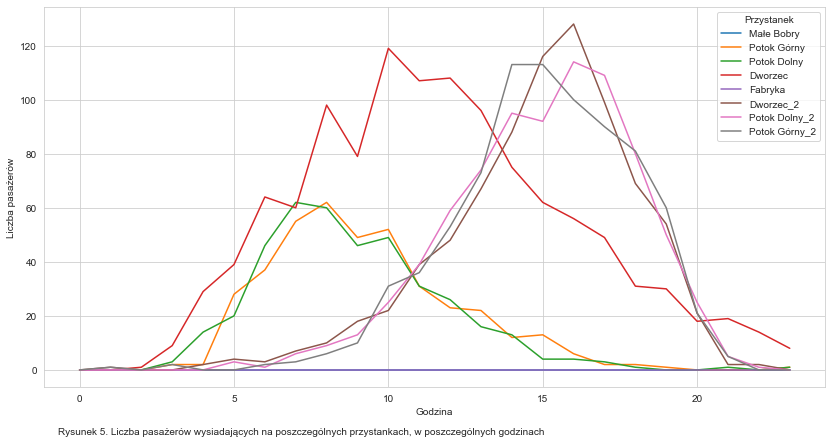

In [11]:
lista_h = []
for h in range(0,24):
    lista = [h]*8
    lista_h += lista
stops = []

for i in range(0,24):
    s = ["Małe Bobry", "Potok Górny", "Potok Dolny", "Dworzec", "Fabryka", 
           "Dworzec_2", "Potok Dolny_2", "Potok Górny_2"]
    stops += s
        
lista_pass_out = []
for key2,value2 in passengers.items():
    for k2, v2 in value2.items():
        if 'out' not in v2:
            lista_pass_out.append(0)
        else:
            lista_pass_out.append(v2['out'])
df = pd.DataFrame({'Godzina': lista_h, 'Przystanek': stops, 'Liczba pasażerów': lista_pass_out} )

fig, ax = plt.subplots(figsize=(14,7)) 
sns.lineplot(data=df,x='Godzina',y='Liczba pasażerów',hue='Przystanek')
plt.text(-.7, -24, 'Rysunek 5. Liczba pasażerów wysiadających na poszczególnych przystankach, w poszczególnych godzinach');

In [12]:
def random_times(n, num_terms = None):
    output = []
    mean = n/num_terms
    for time in range(num_terms):
        if time+1 == num_terms:
            output.append(n - sum(output))
        else:
            output.append(round(random.normal(mean, mean*0.1), 0))
    return output

In [13]:
def model(hour, stats, buses, capacity):
    # filtruje słownik z liczbą pasażerów (na daną godzine)
    stats_hour = stats[hour]
    # inicjuję potrzebne słowniki
    stats_stops = {}
    bus_passengers = {}
    for bus in range(buses):
        bus_passengers[bus+1] = {}
        bus_passengers[bus+1]['in'] = []
        bus_passengers[bus+1]['out'] = []
    # tworzę tuplę z listami wsiadających oraz wysiadających pasażerów z danego busa
    # długość list = liczba busów
    for key, value in stats_hour.items():
        if 'out' in value:
            stats_stops[key] = (random_times(value['in'], buses), random_times(value['out'], buses))
        else:
            stats_stops[key] = (random_times(value['in'], buses),)
    # inicjuję finalną listę z przewiezionymi pasażerami przez konkretne busy
    bus_output = []
    bus_outputall = []
    for bus in range(buses):
        # liczba aktualnych pasażerów w busie
        passengers = 0
        # liczba w sumie przewiezionych pasażerów
        passengers_final = 0
        passengers_all=0
        for key, value in stats_stops.items():
            bus_passengers[bus+1]['in'].append(value[0][bus])
            if len(value) > 1:
                bus_passengers[bus+1]['out'].append(value[1][bus])
            else:
                bus_passengers[bus+1]['out'].append(0)
        for i in range(len(bus_passengers[bus+1]['in'])):
            # i == 4 to rondo onz, zakładamy, że na rondzie ONZ wysiądą wszyscy
            if i == 4:
                passengers = 0
            else:
                passengers -= min(bus_passengers[bus+1]['out'][i], passengers)
            passengers_all+=bus_passengers[bus+1]['in'][i]
            passengers_final += min(capacity-passengers, bus_passengers[bus+1]['in'][i])
            passengers += min(capacity-passengers, bus_passengers[bus+1]['in'][i])
        bus_output.append(passengers_final)
        bus_outputall.append(passengers_all)
    return  bus_output,bus_outputall

In [14]:
# Symulacja z arbitralnymi wartościami

def symulacja_init(iteration, cena_biletu, koszt_autobusu, list_buses, capacity):
    profits = []
    profit_hours = []
    for i in range(iteration):
        random.seed(i)
        r.seed(i)
        profit = 0
        stats = simulate_passengers(cena_biletu)
        iter_profits = []
        for hour in range(24):
            profit_hour = 0
            passengers = model(hour, stats, list_buses[hour], capacity)[0]
            profit += sum([value*cena_biletu for value in passengers])
            profit -= koszt_autobusu*list_buses[hour]
            profit_hour += sum([value*cena_biletu for value in passengers])
            profit_hour -= koszt_autobusu*list_buses[hour]
            iter_profits.append(profit_hour)
        profits.append(profit)
        profit_hours.append(iter_profits)
    return profits, profit_hours

In [15]:
def symulacja(iteration, cena_biletu, koszt_autobusu, buses, capacity):
    profits = []
    optimum_buses = []
    hour_profits_agg = []
    for i in range(iteration):
        random.seed(i)
        r.seed(i)
        profit = 0
        hour_bus = []
        stats = simulate_passengers(cena_biletu)
        hour_profits = []
        for hour in range(24):
            bus_profits = []
            for bus in range(1, buses+1):
                profit = 0
                passengers = model(hour, stats, bus, capacity)[0]
                profit += sum([value*cena_biletu for value in passengers])
                profit -= koszt_autobusu*bus
                bus_profits.append(profit)
            hour_bus.append(bus_profits.index(max(bus_profits))+1)
            hour_profits.append(max(bus_profits))
        profits.append(sum(hour_profits))
        optimum_buses.append(hour_bus)
        hour_profits_agg.append(hour_profits)
    return profits ,optimum_buses, hour_profits_agg

In [16]:
### Kod zmieniony żeby obliczyć ile pasażerów tracimy
def symulacja2(iteration, cena_biletu, koszt_autobusu, buses, capacity):
    profits = []
    optimum_buses = []
    passengers_taken=[]
    passengers_all=[]
    for i in range(iteration):
        random.seed(i)
        r.seed(i)
        profit = 0
        passengerstaken=0
        passengersall=0
        hour_bus = []
        stats = simulate_passengers(cena_biletu)
        hour_profits = []
        for hour in range(24):
            bus_profits = []
            for bus in range(1, buses+1):
                profit = 0
                passengers = model(hour, stats, bus, capacity)[0]
                passengers2=model(hour, stats, bus, capacity)[1]
                profit += sum([value*cena_biletu for value in passengers])
                profit -= koszt_autobusu*bus
                bus_profits.append(profit)
            hour_bus.append(bus_profits.index(max(bus_profits))+1)
            hour_profits.append(max(bus_profits))
            passengerstaken += sum([value for value in passengers])
            passengersall+= sum([value for value in passengers2])
        profits.append(profit)
        optimum_buses.append(hour_bus)
        passengers_all.append(passengersall)
        passengers_taken.append(passengerstaken)
    return passengers_all,passengers_taken

Obecny rozkład jazdy kursowania autobusu prezentuje się następująco:

- 0:00 - 1 bus
- 1:00 - 1 bus
- 2:00 - 1 bus
- 3:00 - 1 bus
- 4:00 - 2 busy
- 5:00 - 2 busy
- 6:00 - 2 busy
- 7:00 - 2 busy
- 8:00 - 3 busy
- 9:00 - 3 busy
- 10:00 - 2 busy
- 11:00 - 2 busy
- 12:00 - 2 busy
- 13:00 - 2 busy
- 14:00 - 2 busy
- 15:00 - 2 busy
- 16:00 - 2 busy
- 17:00 - 2 busy
- 18:00 - 1 busy
- 19:00 - 1 bus
- 20:00 - 1 bus
- 21:00 - 1 bus
- 22:00 - 1 bus
- 23:00 - 1 bus <br><br>

Postaramy się w naszej analizie znaleźć optymalną liczbę busów na daną godzinę, która pozwoli maksymalizować zysk firmie Wesoły Autobus. Cena biletu ponoszona przez pasażera wynosi 2 zł. Koszt przejazdu autobusu wynosi 50 zł. Pojemność busów wynosi 40, a liczba busów we flocie firmy wynosi 6. Poniżej przedstawiono tabelę z liczbą przewiezionych pasażerów oraz liczbą "straconych" pasażerów, których utraciliśmy z powodu niskiej pojemności busa oraz małej liczby busów.

In [17]:
iteration=10
ceny =2
koszt_autobusu=50
buses=range(1,7,1)
capacity=40
data4 = pd.DataFrame()

for b in buses:
    data4 = data4.append({"Dopuszczone busy": b, 
                "Liczba wszystkich pasażerów": sum(symulacja2(iteration, ceny, koszt_autobusu, b, capacity)[0]),
               "Liczba przewiezionych pasażerów": sum(symulacja2(iteration, ceny, koszt_autobusu, b, capacity)[1])}, ignore_index=True)




In [18]:
data4["Liczba straconych pasażerów"]=data4["Liczba wszystkich pasażerów"]-data4["Liczba przewiezionych pasażerów"]

In [19]:
data4

,Dopuszczone busy,Liczba przewiezionych pasażerów,Liczba wszystkich pasażerów,Liczba straconych pasażerów
0,1.0,34226.0,59706.0,25480.0
1,2.0,47142.0,59706.0,12564.0
2,3.0,53090.0,59706.0,6616.0
3,4.0,56842.0,59706.0,2864.0
4,5.0,58850.0,59706.0,856.0
5,6.0,59543.0,59706.0,163.0


Obecnie na trasie jeżdżą maksymalnie 3 busy przy cenie biletu 2 zł. Analizując powyższą tabelę widzimy, że przy takim układzie wiele pasażerów nie jest w stanie wsiąść do autobusów, przez co firma traci potencjalne zyski. W dalszej szczęści raportu zostanie określony optymalny rozkład busów na daną godzinę oraz optymalna cena, która umożliwi nam maksymalizację zysku.

## 5. Wyniki analizy

<br> W tej części raportu zostaną przedstawione wyniki analizy, które mają na celu wskazać optymalną liczbę autobusów na każdą godzinę dnia oraz cenę biletu.

### 5.1 Wybór optymalnej liczby autobusów dla każdej godziny
<br> Liczba pasażerów w danych godzinach nie jest stała i zależy od pory dnia. Dlatego poniższa analiza będzie starała się rozwiązać problem optymalnej liczby busów w zależności od godziny kursu. W pierwszej kolejności zostanie przeanalizowany obecny rozkład kursowania busa.

In [19]:
initial = [1] * 4 + [2] *4 + [3] * 2 + [2]*8 + [1]*6
iteration=10
ceny =2
koszt_autobusu=50
buses=6
capacity=40
output = symulacja_init(iteration, ceny, koszt_autobusu, initial, capacity)

Poniżej możemy zauważyć jaki był średni zysk całodobowy dla dziesięciu kolejnych dni.

In [20]:
day = 1
for zysk in output[0]:
    print(f"Zysk całodobowy dla {day} dnia symulacji wyniósł: {zysk} zł")
    day += 1

Zysk całodobowy dla 1 dnia symulacji wyniósł: 7448.0 zł
Zysk całodobowy dla 2 dnia symulacji wyniósł: 7402.0 zł
Zysk całodobowy dla 3 dnia symulacji wyniósł: 7372.0 zł
Zysk całodobowy dla 4 dnia symulacji wyniósł: 7346.0 zł
Zysk całodobowy dla 5 dnia symulacji wyniósł: 7390.0 zł
Zysk całodobowy dla 6 dnia symulacji wyniósł: 7372.0 zł
Zysk całodobowy dla 7 dnia symulacji wyniósł: 7482.0 zł
Zysk całodobowy dla 8 dnia symulacji wyniósł: 7400.0 zł
Zysk całodobowy dla 9 dnia symulacji wyniósł: 7360.0 zł
Zysk całodobowy dla 10 dnia symulacji wyniósł: 7422.0 zł


Teraz zostanie zaproponowana symulacja, w której będziemy optymalizować liczbę busów na każdą godzinę. Poniżej przedstawiono zysk całodobowy dla dziesięciu kolejnych dni.

In [21]:
output_optim = symulacja(iteration, ceny, koszt_autobusu, buses, capacity)
day = 1
for zysk in output_optim[0]:
    print(f"Zysk całodobowy dla {day} dnia symulacji wyniósł: {zysk} zł")
    day += 1

Zysk całodobowy dla 1 dnia symulacji wyniósł: 8246.0 zł
Zysk całodobowy dla 2 dnia symulacji wyniósł: 8174.0 zł
Zysk całodobowy dla 3 dnia symulacji wyniósł: 8180.0 zł
Zysk całodobowy dla 4 dnia symulacji wyniósł: 8200.0 zł
Zysk całodobowy dla 5 dnia symulacji wyniósł: 8206.0 zł
Zysk całodobowy dla 6 dnia symulacji wyniósł: 8188.0 zł
Zysk całodobowy dla 7 dnia symulacji wyniósł: 8146.0 zł
Zysk całodobowy dla 8 dnia symulacji wyniósł: 8132.0 zł
Zysk całodobowy dla 9 dnia symulacji wyniósł: 8206.0 zł
Zysk całodobowy dla 10 dnia symulacji wyniósł: 8242.0 zł


Na pierwszy rzut oka można zauważyć, że zyski są średnio o około 800 zł wyższe na każdy dzień symulacji. Przeanalizujmy teraz jaka była najczęstsza liczba busów w zależności od godziny.

In [22]:
def my_mode(sample):
    c = Counter(sample)
    return [k for k, v in c.items() if v == c.most_common(1)[0][1]]

In [23]:
optim_sol = []
for hour in range(24):
    buses = []
    for day in output_optim[1]:
        buses.append(day[hour])
    print(f"Optymalna liczba busów dla godziny {hour} wynosi {my_mode(buses)[0]}")
    optim_sol.append(my_mode(buses)[0])

Optymalna liczba busów dla godziny 0 wynosi 1
Optymalna liczba busów dla godziny 1 wynosi 1
Optymalna liczba busów dla godziny 2 wynosi 1
Optymalna liczba busów dla godziny 3 wynosi 1
Optymalna liczba busów dla godziny 4 wynosi 1
Optymalna liczba busów dla godziny 5 wynosi 2
Optymalna liczba busów dla godziny 6 wynosi 4
Optymalna liczba busów dla godziny 7 wynosi 5
Optymalna liczba busów dla godziny 8 wynosi 5
Optymalna liczba busów dla godziny 9 wynosi 5
Optymalna liczba busów dla godziny 10 wynosi 4
Optymalna liczba busów dla godziny 11 wynosi 4
Optymalna liczba busów dla godziny 12 wynosi 3
Optymalna liczba busów dla godziny 13 wynosi 2
Optymalna liczba busów dla godziny 14 wynosi 2
Optymalna liczba busów dla godziny 15 wynosi 3
Optymalna liczba busów dla godziny 16 wynosi 4
Optymalna liczba busów dla godziny 17 wynosi 4
Optymalna liczba busów dla godziny 18 wynosi 4
Optymalna liczba busów dla godziny 19 wynosi 3
Optymalna liczba busów dla godziny 20 wynosi 2
Optymalna liczba busów 

Możemy zauważyć, że optymalny rozkład jazdy różni się od tego, który jest teraz wykorzystywany. Przy takich zadanych wartościach parametrów optymalny rozkład jazdy busów na daną godzine prezentuje się jak powyżej. Porównano teraz średnie zyski z 10 dni dla każdej godziny pomiędzy rozkładem zastanym a optymalnym.

In [24]:
hour_profits_1 = []
for hour in range(24):
    profits = []
    for day in output[1]:
        profits.append(day[hour])
    hour_profits_1.append(np.mean(profits))

In [25]:
hour_profits_2 = []
for hour in range(24):
    profits = []
    for day in output_optim[2]:
        profits.append(day[hour])
    hour_profits_2.append(np.mean(profits))

Text(-1, -250, 'Rysunek 6. Porównanie średnich zysków na godzine dla rozkładu zastanego oraz optymalnego. \nDla każdej godziny optymalny rozkład jazdy daje średni wyższe zyski')

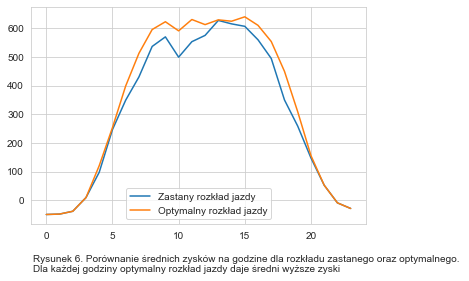

In [26]:
hours = [hour for hour in range(24)]
plt.plot(hours, hour_profits_1, label = "Zastany rozkład jazdy")
plt.plot(hours, hour_profits_2, label = "Optymalny rozkład jazdy")
plt.legend()
plt.text(-1, -250,"Rysunek 6. Porównanie średnich zysków na godzine dla rozkładu zastanego oraz optymalnego. \n"
                "Dla każdej godziny optymalny rozkład jazdy daje średni wyższe zyski")

### 5.2 Wybór optymalnej ceny w zależności od typu busa
<br>Poniżej przeprowadzono analizę w celu określenia optymalnej ceny biletu w zależności od typu busa oraz dopuszczonej liczby busów na trasie. Firma posiada we flocie 4 typy autobusów. Prezes zastanawia się jakiej wielkości busy powinny jeździć na trasie. Poniższy wykres przedstawia jak plasują się zyski i cena biletu dla dostępnych typów busa. Liczba maksymalnych dopuszczonych busów na trasie wynosi 5.

In [27]:
### Symulacja zysku w zależności od ceny biletu, pojemności busa i kosztu busa 
iteration=10
ceny =np.arange(1, 4.2,0.2).round(1)
koszt_autobusu=[40,50,70,90]
buses=5
capacity=[30,40,50,60]
data6 = pd.DataFrame()
for p in ceny:
    for i in range(len(capacity)):
            data6 = data6.append({"Cena":p, "Pojemność busa": capacity[i], "Typ busa": str(capacity[i])+" osób"+" - "+str(koszt_autobusu[i])+" zł",
                                "Zysk": mean(symulacja(iteration, p, koszt_autobusu[i], buses, capacity[i])[0])}, ignore_index=True)

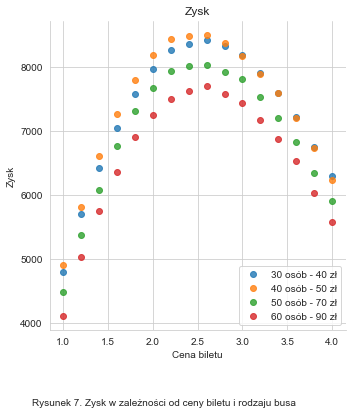

In [28]:
p = sns.lmplot( x="Cena", y="Zysk", data=data6, fit_reg=False, hue="Typ busa", legend=False)
plt.legend(loc='lower right')
plt.xlabel('Cena biletu')
plt.ylabel('Zysk')
p.fig.text(0.1, -0.1,'Rysunek 7. Zysk w zależności od ceny biletu i rodzaju busa')
plt.title('Zysk');

Analizując Rysunek 7 widzimy, że bus, który przewozi 40 osób jest optymalnym wyborem przy cenie biletu 2,6 zł. 

Poniżej przeprowadzono analizę zysku w zależności od ceny biletu oraz liczby dopuszczonych autobusów na trasie dla przyjętego kosztu przejazdu atobusu równego 50 zł oraz pojemności jednego busa 40 osób. Największy zysk firma wypracuje jeśli przyjmie cenę biletu na poziomie 2,6 zł. Firmie nie opłaca się wysyłać na trasę wiecej niż 4 autobusy na godzinę, ponieważ nie generuje to większych zysków.

In [29]:
### Symulacja zysku od ceny i liczby busów
iteration=10
ceny =np.arange(0.0, 4.2,0.2).round(1)
koszt_autobusu=50
buses=range(1,7,1)
capacity=40
data2 = pd.DataFrame()

for p in ceny:
    for b in buses:
        data2 = data2.append({"Cena":p, "Dopuszczone busy": b, 
                            "Zysk": mean(symulacja(iteration, p, koszt_autobusu, b, capacity)[0])}, ignore_index=True)



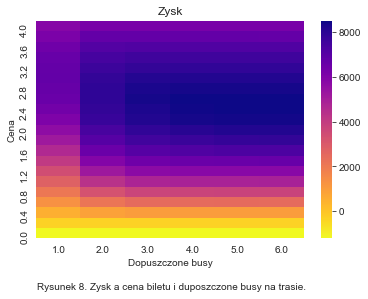

In [30]:
test_pivoted=data2.pivot("Cena","Dopuszczone busy","Zysk")
ax=sns.heatmap(test_pivoted, cmap=cm.plasma_r)
ax.invert_yaxis()
ax.set_title('Zysk')
ax.text(0.01, -5, "Rysunek 8. Zysk a cena biletu i duposzczone busy na trasie.", ha='left')
plt.show()

## 6. Analiza wrażliwości

<br> W tej części raportu zostanie przeprowadzona analiza skutków zmiany wybranych kluczowych parametrów. Pomoże to odpowiedzieć na pytanie, jak zmiana parametrów wpłynie na rozwiązanie optymalne.

### 6.1 Analiza optymalnej liczby busów na daną godzinę w zależności od liczby dopuszczonych busów oraz ceny biletu

In [16]:
### Symulacja optymalnej liczby busów od ceny biletu, liczby busów i godziny
iteration=15
cena_biletu =np.arange(0, 4.2,0.2)
koszt_autobusu=50
buses=6
capacity=40

def symulacja4(iteration, cena_biletu, koszt_autobusu, buses, capacity):
    data1 = pd.DataFrame()
    profits = []
    optimum_buses = []
    for i in range(iteration):
        for p in cena_biletu:
            random.seed(i)
            r.seed(i)
            profit = 0
            hour_bus = []
            stats = simulate_passengers(p)
            hour_profits = []
            for hour in range(24):
                bus_profits = []
                for bus in range(1, buses+1):
                    profit = 0
                    passengers = model(hour, stats, bus, capacity)[0]
                    profit += sum([value*p for value in passengers])
                    profit -= koszt_autobusu*bus
                    bus_profits.append(profit)
                    data1 = data1.append({"Cena":p,"Dopuszczone busy": bus, "Godzina":hour,
                "liczba busów":bus_profits.index(max(bus_profits))+1 }, ignore_index=True)
                hour_bus.append(bus_profits.index(max(bus_profits))+1)
                hour_profits.append(max(bus_profits))
            profits.append(sum(hour_profits))
            optimum_buses.append(hour_bus)
    return data1

data1=symulacja4(iteration, cena_biletu, koszt_autobusu, buses, capacity).groupby(['Dopuszczone busy','Cena','Godzina'])['liczba busów'].median().round(0).reset_index()


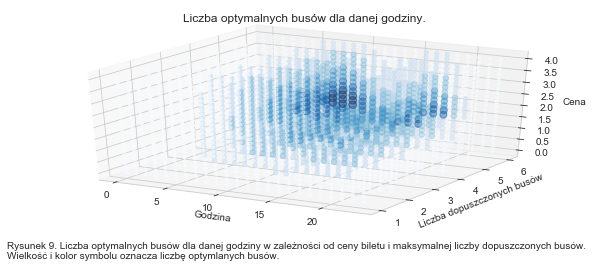

In [17]:
x_line=data1['Godzina']
y_line=data1['Dopuszczone busy']
z_line=data1['Cena']
l_b=data1['liczba busów']*10

fig = plt.figure(
    figsize=plt.figaspect(0.4)
)
ax = fig.add_subplot(1,1,1, projection='3d')
scat1=ax.scatter3D(x_line, y_line, z_line, 'gray', s=l_b,c=l_b, marker='o',cmap = cm.Blues)

ax.set_xlabel("Godzina")
ax.set_ylabel("Liczba dopuszczonych busów")
ax.set_zlabel("Cena")
ax.set_title("Liczba optymalnych busów dla danej godziny.",size=12)
fig.text(.1, -0.02, "Rysunek 9. Liczba optymalnych busów dla danej godziny w zależności od ceny biletu i maksymalnej liczby dopuszczonych busów. \n"
                     "Wielkość i kolor symbolu oznacza liczbę optymlanych busów.  \n", ha='left')
plt.show()

Analiza powyższego wykresu pozwala zauważyć, że w godzinach porannych oraz nocnych potrzeba jedynie jednego autobusu na trasie. Dodatkowo widzimy, że wraz ze wzrostem liczby dopuszczonej liczby busów na trasie wzrasta ich optymalna liczba w godzinach szczytowych. Oczywiście dla wyższych wartości ceny biletu, tak od 3 zł, liczba optymalnych autobusów zaczyna spadać, ponieważ klienci rezygnują.

### 6.2 Analiza wpływu ilości symulacji na zysk całodobowy

W celu zbadania wpływu ilości symulacji na zysk całodobowy firmy, przeprowadzono symulację przy założeniu stałych parametrów. Liczba iteracji wynosi kolejno 10, 50, 100, 200 , 400 oraz 800 iteracji. Cena biletu 2 PLN. Koszt autobusu 50 PLN. Pojemność jednego autobusu 40 pasażerów. 

In [31]:
# Nowa funkcja ceny - wybieramy tą
def f(cena=0):
    if cena <= 6:
        wspolczynnik = round(4/(1/2*cena+1)-1,3)
    else: 
        wspolczynnik = 0
    return wspolczynnik

In [32]:
iterations = [10, 50, 100, 200, 400, 800]
ceny =2
koszt_autobusu=50
buses=6
capacity = 40
df = pd.DataFrame()
średni_zysk = []
odchylenia = []
liczba_iteracji = []
buses = 6
for i in iterations:
    x = symulacja(i, ceny, koszt_autobusu, buses, capacity)
    średni_zysk.append(np.mean(x[0]))
    odchylenia.append(np.std(x[0]))

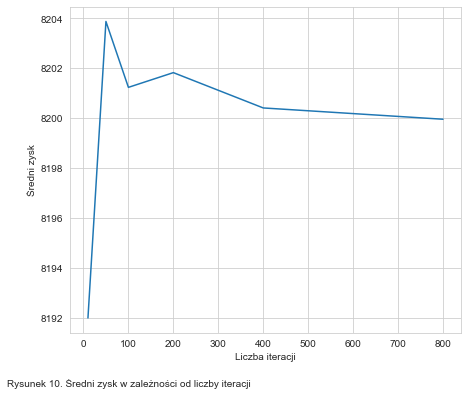

In [33]:
fig1 = plt.figure(figsize=(7, 6))
plt.plot(iterations, średni_zysk)
plt.ylabel('Średni zysk')
plt.xlabel('Liczba iteracji')
fig1.text(0, 0, "Rysunek 10. Średni zysk w zależności od liczby iteracji");

Z analizy wynika, że do 50 iteracji włącznie średni zysk wzrasta i od mniej więcej 100 liczby symulacji zaczyna spadać i stabilizować się na poziomie 8200. Możemy wnioskować, że dalsze zwiększanie liczby iteracji nie wpłynie znacząco na średni zysk, więc pod tym względem nasz model symulacji jest stabilny. 


W dalszym kroku przeprowadzono analizę wartości odchylenia standardowego zysku dobowego w zależności od liczby powtórzeń symulacji. Maksymalna liczba iteracji = 800. Przyjęto przy tym stały koszt biletu na poziomie 2 zł, koszt przejazdu autobusu kształtujący się na poziomie 50 zł oraz liczbę wypuszczanych autobusów = 6 oraz pojemność autobusu = 40.

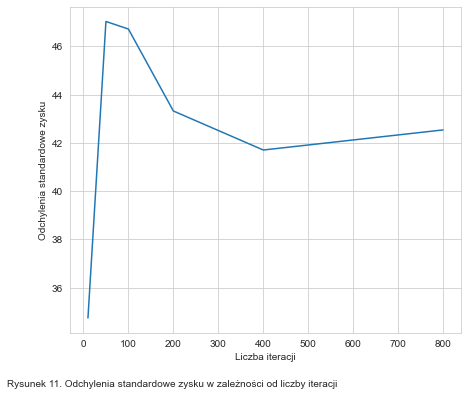

In [34]:
fig1 = plt.figure(figsize=(7, 6))
plt.plot(iterations, odchylenia)
plt.ylabel('Odchylenia standardowe zysku')
plt.xlabel('Liczba iteracji')
fig1.text(0, 0, "Rysunek 11. Odchylenia standardowe zysku w zależności od liczby iteracji");

Na powyższym wykresie widać, że odchylenie standardowe wacha się w granicach 36 - 46 zł. 
Podobnie jak na wcześniejszym wykresie widzimy wzrost odchylenia standardowego zysku od 10 symulacji do 50-ciu, a później od liczby symulacji = 100 spadek i stabilizacje na poziomie ok. 42 zł. Zwiększając liczbę iteracji odchylenie standardowe dla zysku jest stabilne. 

W następnym kroku przeprowadzimy analizę wrażliwości dla następujących parametrów: cena, liczba autobusów, pojemność autobusu czy koszt autobusu. 


### 6.3 Analiza zmiany ceny biletu, liczby maksymalnych autobusów w ciągu dnia, pojemności pojedynczego busa oraz kosztu autobusu na zysk całodniowy oraz optymalną liczbę busów na daną godzinę 

Poniższa wielowektorowa analiza umożliwi podjęcie optymalnej decyzji osobom zarządzającym firmą Wesoły Autobus dotyczącej optymalnej liczby busów na daną godzinę. Tylko na niektóre parametry w naszym modelu, firma Wesoły Autobus ma wpływ i może je zmieniać w danym momencie. Przykładowo, pojemność busa jest w pewnym sensie sztywnym parametrem. Oczywiście firma ma możliwość zakupu floty busów o większej pojemności, lecz może się okazać to długotrwałym procesem. Również koszt autobusu nie jest zależny od decyzji kadry zarządzającej firmą Wesoły Autobus. Jest to koszt jaki musi ponieść firma w związku z aktywnością jednego busa przez godzinę. Składa się na to koszt paliwa, amortyzacja autobusu oraz wynagrodzenie kierowcy. Sytuacja na rynku paliwowym bądź na rynku pracy może ulec zmianie. Istotnym jest więc przeanalizowanie również wpływu zmiany tych parametrów na rozwiązanie optymalne. <br>

Do analizy przyjęto różne zakresy parametrów. Poniżej przedstawiono analizowane zakresy poszczególnych parametrów:

- cena biletu: <1, 4> z granulacją co 0.5
- maksymalna dopuszczalna liczba busów: od 3 do 6
- pojemność busa <20, 50> z granulacją co 10
- godzinowy koszt busa: <40, 90> z granulacją co 10
- liczba iteracji dla każdego zestawu parametrów: 5

In [35]:
ceny = [1, 1.5, 2, 2.5, 3, 3.5, 4]
max_buses = range(3, 7)
capacity = [20, 30, 40, 50]
cost_buses = range(40, 100, 10)

In [36]:
data = pd.DataFrame()
for cena in ceny:
    for bus in max_buses:
        for cap in capacity:
            for cost in cost_buses:
                output = symulacja(5, cena, cost, bus, cap)
                i = 0
                for iteration in output[1]:
                    hour = 0
                    for bus_value in iteration:
                        data = data.append({"Cena": cena, "Koszt": cost, "Maksymalna liczba busów": bus, 
                                            "Pojemność busa": cap, "Godzina": hour, 
                                            "Optymalna liczba": bus_value, "Zysk całodniowy": output[0][i]},
                                           ignore_index=True)
                        hour += 1
                    i += 1
                

In [37]:
data_profits = data.drop(["Godzina", "Optymalna liczba"], axis=1).drop_duplicates()
data_profits = data_profits.groupby(["Cena", "Koszt", "Maksymalna liczba busów", 
                                     "Pojemność busa"]).mean().reset_index()
data_profits_1 = {i: data_profits[(data_profits["Maksymalna liczba busów"]==6) & (data_profits['Cena']==i)].reset_index().\
       pivot("Pojemność busa", "Koszt", "Zysk całodniowy") for i in range(1, 5)}

W pierwszej kolejności zostały przedstawione 4 wykresy typu 'heatmap', które pokazują zmiany średniego zysku całodniowego w zależności od pojemności pojedynczego busa, kosztu godzinnego jednego busa oraz czterech różnych cen z przedziału <1, 4> co 1 zł. Wykresy zostały utworzone dla ustalonej liczby busów równej 7.

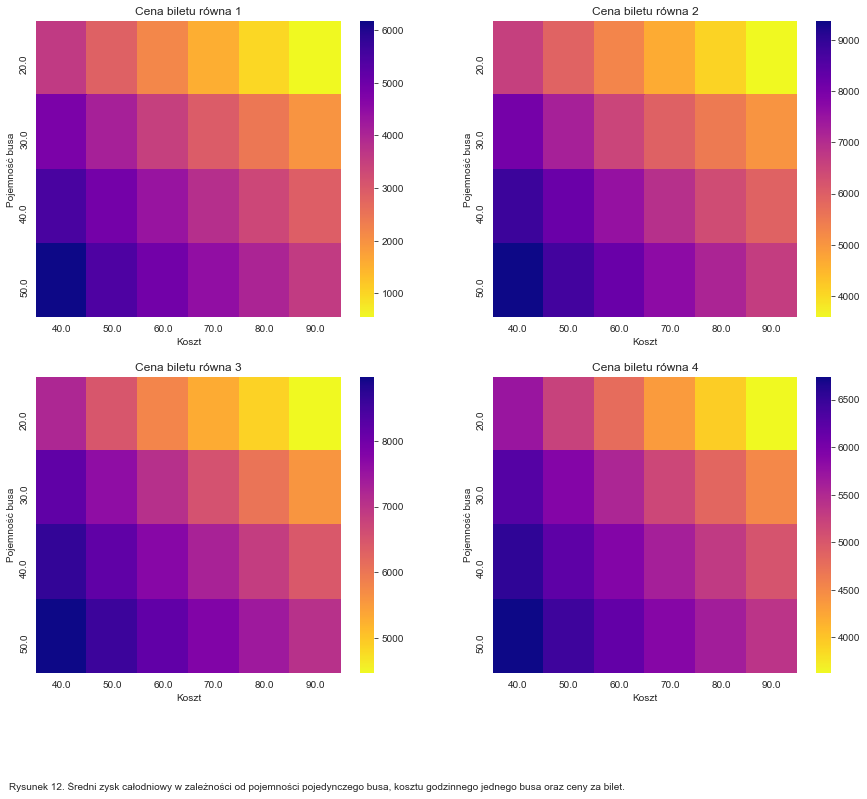

In [38]:
fig2, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 12))
for i, ax in enumerate(axes.flatten()):
    sns.heatmap(data_profits_1[i+1], cmap=cm.plasma_r, ax=ax)
    ax.set_title(f"Cena biletu równa {i+1}")
    if i > 4:
        ax.get_xaxis().set_visible(False)
fig2.text(.1, -0.01, "Rysunek 12. Średni zysk całodniowy w zależności od pojemności pojedynczego busa, kosztu godzinnego jednego busa oraz ceny za bilet.", ha='left')        
plt.show();

Z powyższych wykresów wynikają dość naturalne wnioski. W pierwszej kolejności średni zysk dobowy rośnie wraz ze wzrostem ceny do pewnego momentu, do ceny równej 2 zł. W każdym z przedstawionych powyżej wykresów średni zysk rośnie wraz ze spadkiem kosztu autobusu za godzinę użytkowania. Odwrotna zależność ma miejsce z pojemnością busa. Wraz ze wzrostem pojemności busa nasze średnie zyski rosną. Pojemność busa niweluje godzinny koszt autobusu. Przykładowo we wszystkich wykresach średnie zyski są podobne dla dwóch zestawów parametrów: koszt autobusu równa się 80, a pojemność 50 daje podobne średnie zyski co zestaw parametrów: koszt równy 50, a pojemność busa równa się 30. W następnej kolejności zostanie przedstawiony wykres najczęstej optymalnej liczby busów na daną godzinę w zależności od pojemności busa, przyjmując maksymalną liczbę busów równą 6.

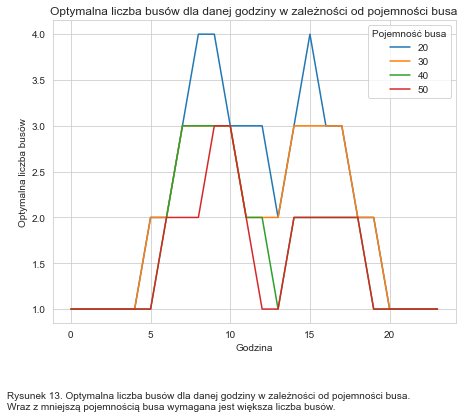

In [39]:
dfs_grouped = {}
for cap in capacity:
    df = data[(data["Maksymalna liczba busów"]==6) & (data['Pojemność busa']==cap)]
    grouped = df.groupby(['Godzina'])['Optymalna liczba'].agg(lambda x:x.value_counts().index[0]).reset_index()
    dfs_grouped[cap] = grouped
fig1 = plt.figure(figsize=(7, 6))
ax1 = fig1.add_axes((0.1, 0.2, 0.8, 0.7))
for cap in capacity:
    ax1.plot(dfs_grouped[cap]['Godzina'], dfs_grouped[cap]['Optymalna liczba'], label=cap)
ax1.legend(loc=1, title='Pojemność busa')
plt.ylabel('Optymalna liczba busów')
plt.xlabel('Godzina')
plt.title('Optymalna liczba busów dla danej godziny w zależności od pojemności busa')
fig1.text(.01, .001, 
          "Rysunek 13. Optymalna liczba busów dla danej godziny w zależności od pojemności busa. \n"
          "Wraz z mniejszą pojemnością busa wymagana jest większa liczba busów.");

Na podstawie powyższego wykresu możemy dojść do ciekawych wniosków. Przykładowo, optymalna liczba busów jest najwyższa gdy mamy najniższą pojemność busa dla wszystkich godzin. Zasadniczo, najwięcej busów firma Wesoły Autobus powinna wypuszczać w godzinach między 8 a 10  oraz około między 14 a 17 dla każdej wersji pojemności busa. 

 W celu pogłębionej analizy problemu optymalnej liczby busów została podjęta próba utworzenia drzewa decyzyjnego. Zmiennymi objaśnianymi zostały wybrane parametry takie jak cena biletu, pojemność busa, godzinny koszt busa oraz godzina kursu.

In [40]:
# d = {'L': 0, 'G': 1}
# grouped['Ustawienie'] = grouped['Ustawienie'].map(d)
features = ["Cena", 'Pojemność busa', "Godzina", "Koszt"]
# X = grouped[features]
# y = grouped["Liczba narzedzi"]
X_train, X_test, Y_train, Y_test = train_test_split(data[features], data["Optymalna liczba"], random_state=0)
dtree = DecisionTreeClassifier(max_depth=10, random_state=0)
dtree = dtree.fit(X_train, Y_train)
score = dtree.score(X_test, Y_test)
print(score)

0.7777281746031746


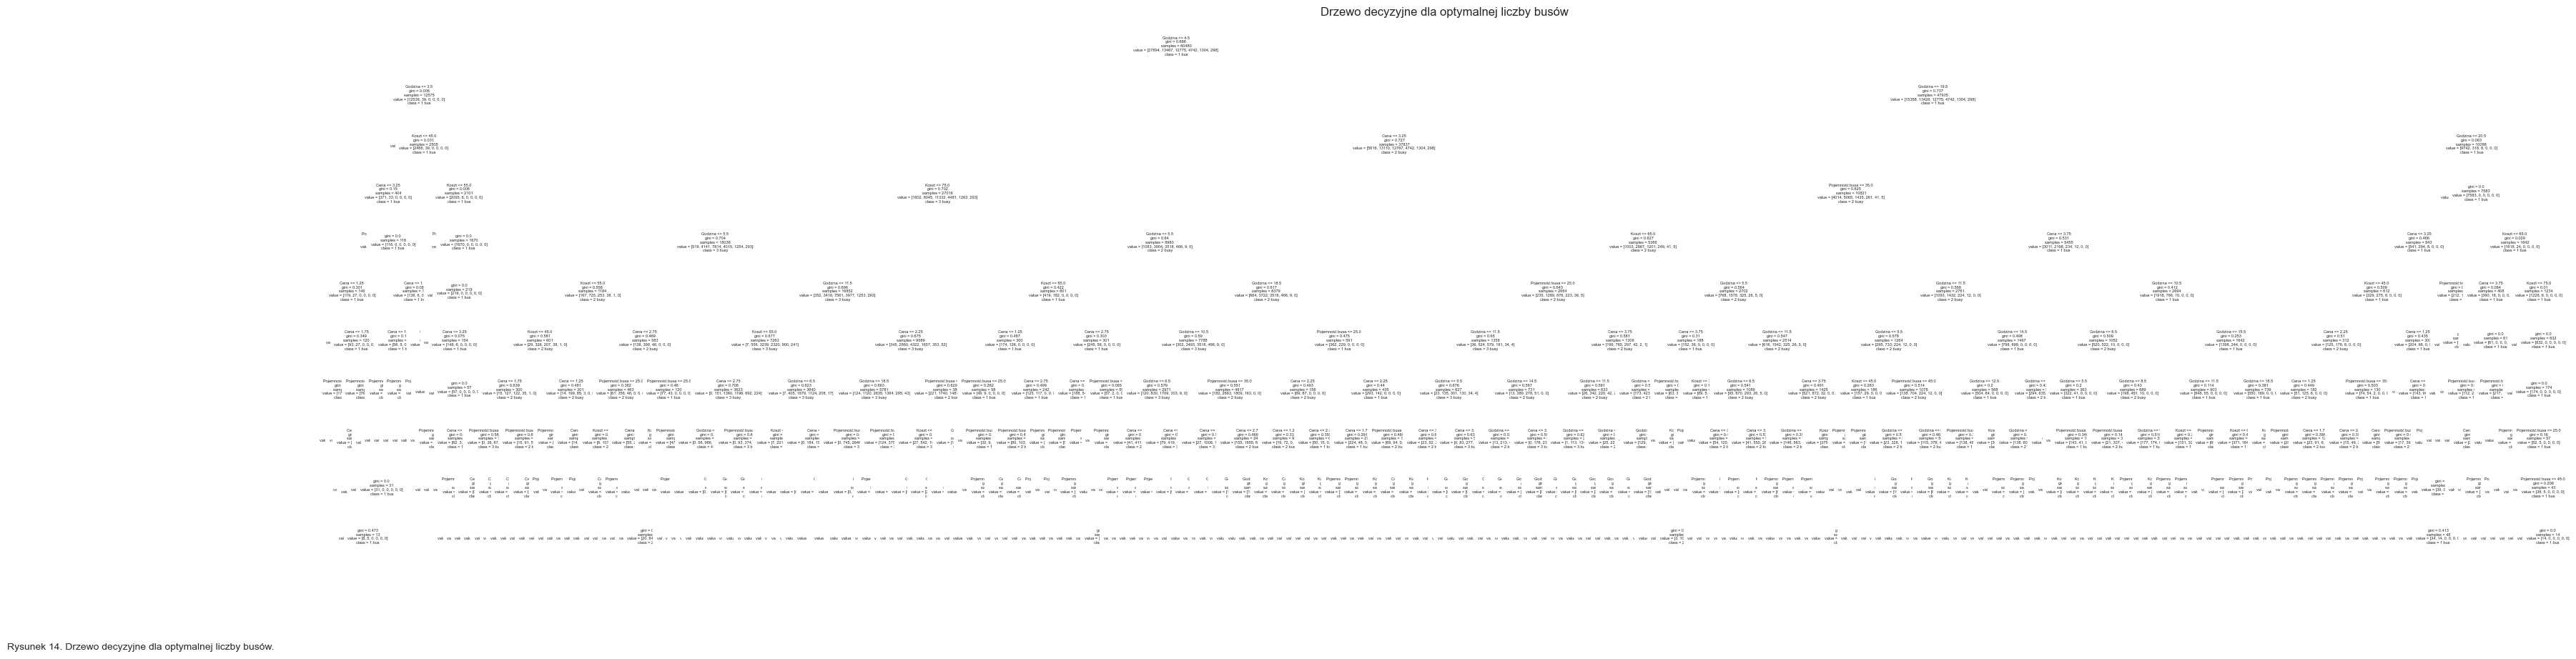

In [41]:

fig, axes = plt.subplots(figsize = (40,10), dpi=100)
tree.plot_tree(dtree, feature_names=features,
              class_names=['1 bus', '2 busy', '3 busy', '4 busy', '5 busów', '6 busów'],
              fontsize=4)
plt.title('Drzewo decyzyjne dla optymalnej liczby busów')
fig.text(.01, .001, 
          "Rysunek 14. Drzewo decyzyjne dla optymalnej liczby busów.")
fig.savefig('tree.png')

W pierwszej kolejności zestaw danych został podzielony na zbiór uczący (75 % pierwotnego zbioru) oraz testowy (25 % pierwotnego zbioru). Następnie został utworzony model drzewa decyzyjnego z maksymalną głebokością korzeni równą 10. Trafność optymalnych decyzji wynosi około 78 %, co jest zadowalającym rezultatem. Na powyższym wykresie jest zwizualizowane drzewo decyzyjyne. Nie jest ono zbyt czytelne w jupyter notebooku, więc zostało zapisane do oddzielnego pliku. Takie drzewo decyzyjne będzie pomocne dla przedsiębiorstwa w kwestii podjęcia dezycji odnośnie optymalnej liczby busa na daną godzinę w zależności od innych parametrów. Możemy natomiast przewidzieć jaka powinna być optymalna liczba busów w zależności od innych parametrów. Według poniższego wyniku, w sytuacji gdy cena równa się 2, pojemność busa wynosi 50, godzinny koszt autobusu wynosi 60 to o godzinie 18 firma powinna wypuścić 3 busy. Natomiast jeśli cena za bilet wynosi 3 zł, pojemność busa wynosi 30 a godzinny koszt autobusu wynosi 40, optymalna liczba busów o godzinie 8 to 4.

In [42]:
dtree.predict(np.array([2, 50, 18, 60]).reshape(1, -1))

array([3.])

In [43]:
dtree.predict(np.array([3, 30, 8, 40]).reshape(1, -1))

array([4.])